# Factor Style Rotation (Kospi 200) [Logistic Regression etc.]

In [1]:
import pyodbc
import pandas as pd
from datetime import datetime
import numpy as np
import itertools
import time
from sklearn.preprocessing import MinMaxScaler


import os
os.chdir('')
import functions_0 as mf0
import functions_1 as mf1

conn_quant = pyodbc.connect('driver={SQL Server};server=')
conn_wisefn = pyodbc.connect('driver={SQL Server};server=')
conn_pcor = pyodbc.connect('driver={Oracle in OraClient12Home1};')

## Factor Information (Team DB)

In [2]:
sql_factor_info = '''  select FactorCode, FactorDesc_, FactorGroup, FactorGroup_sub,Reverse_ , D_cnt
                        from 
                        where Model_yn = 1 and D_cnt > 200  '''

factor_info = pd.read_sql(sql_factor_info, conn_quant)

In [3]:
factor_info = factor_info.replace({'':np.NaN})
factor_info = factor_info.fillna(method='ffill', axis = 1)
factor_info = factor_info.rename(columns = {'FactorGroup':'Group','FactorGroup_sub':'FactorGroup'})

In [4]:
factor_info

,FactorCode,FactorDesc_,Group,FactorGroup,Reverse_,D_cnt
0,211000_FQ0,Operating Profit/Sales,Quality,Profitability,1,281
1,211100_FQ0,Pre-tax Profit from Continuing Operations/Sales,Quality,Profitability,1,281
2,211200_FQ0,Net Income/Sales,Quality,Profitability,1,278
3,211200_FY0,Net Income/Sales,Quality,Profitability,1,278
4,211300_FQ0,Gross Margin,Quality,Profitability,1,281
...,...,...,...,...,...,...
78,REV_Chg_FY1_3M,REV_Chg_FY1_3M,Momentum,Sentiment,1,223
79,REV_ERR_FQ1_3M,REV_ERR_FQ1_3M,Momentum,Sentiment,1,256
80,REV_ERR_FY1_3M,REV_ERR_FY1_3M,Momentum,Sentiment,1,286
81,SP_TTM,SalesYield TTM,Value,Value,1,286


## BM 구성종목 (월별)

In [5]:
sql_ksp200_cnst = '''  SELECT A.TRD_DT, CONVERT(DATE,B.DT,12) AS ScoreDate, 'A'+A.STK_CD AS Code
                        FROM  A
                        LEFT JOIN (select DT, YMD
                                    from 
                                    WHERE MN_END_YN = 1 AND YMD > '20000101') B
                            ON A.TRD_DT = B.YMD
                        WHERE 1=1
                            AND KS200_TYP = 1
                            AND TRD_DT IN (select YMD
                                            from 
                                            WHERE MN_END_YN = 1 AND YMD > '20000101')  '''
ksp200_cnst = pd.read_sql(sql_ksp200_cnst, conn_wisefn)

In [6]:
ksp200_cnst.head(10)

,TRD_DT,ScoreDate,Code
0,20231031,2023-10-31,A079550
1,20231031,2023-10-31,A081660
2,20231031,2023-10-31,A086280
3,20231031,2023-10-31,A086790
4,20231031,2023-10-31,A088350
5,20231031,2023-10-31,A090430
6,20231031,2023-10-31,A093370
7,20231031,2023-10-31,A096770
8,20231031,2023-10-31,A097950
9,20231031,2023-10-31,A103140


In [7]:
# 팩터 리스트, 중복제거 종목 리스트
factor_list = tuple(factor_info['FactorCode'].unique())
stk_unique_list = tuple(ksp200_cnst['Code'].unique())

## Factor Score (월별)

In [8]:
sql_factor_data = f'''  select ScoreDate, FactorCode, Code, Ratio
                        from 
                        where 1=1
                        and FactorCode in {factor_list}
                        and Code in {stk_unique_list} '''

factor_data = pd.read_sql(sql_factor_data, conn_quant)

In [9]:
ksp200_factors = pd.merge(ksp200_cnst,factor_data, 'left', ['ScoreDate','Code'])

In [10]:
ksp200_factors = pd.merge(ksp200_factors, factor_info[['FactorCode','FactorGroup','Reverse_']], 'left', 'FactorCode')

In [11]:
# 삼성전자 예시
ksp200_factors[ksp200_factors['Code']=='A005930']

,TRD_DT,ScoreDate,Code,FactorCode,Ratio,FactorGroup,Reverse_
7137,20231031,2023-10-31,A005930,211100_FQ0,0.028550,Profitability,1
7138,20231031,2023-10-31,A005930,211600_FQ0,0.003820,Profitability,1
7139,20231031,2023-10-31,A005930,211200_FQ0,0.028720,Profitability,1
7140,20231031,2023-10-31,A005930,211200_FY0,0.184140,Profitability,1
7141,20231031,2023-10-31,A005930,222600_FQ0,-12.025020,Stability,1
...,...,...,...,...,...,...,...
3687724,20000831,2000-08-31,A005930,EPS_ERR_FY1_3M,0.000000,Sentiment,1
3687725,20000831,2000-08-31,A005930,BETA(60D),1.383190,Market,-1
3687726,20000831,2000-08-31,A005930,BTM_QW,0.315535,Value,1
3687727,20000831,2000-08-31,A005930,OCFY_TTM,NaN,Value,1


In [12]:
ksp200_factors_pivot = pd.pivot(ksp200_factors, index=['TRD_DT','ScoreDate','Code'], columns = ['FactorCode','FactorGroup','Reverse_'], values = 'Ratio')

In [13]:
# 종목, 팩터순으로 정리한 데이터프레임 예시
ksp200_factors_pivot.tail(10)

FactorCode                     211000_FQ0    211600_FQ0    211500_FQ0  \
FactorGroup                 Profitability Profitability Profitability   
Reverse_                              1.0           1.0           1.0   
TRD_DT   ScoreDate  Code                                                
20231130 2023-11-30 A329180           NaN           NaN           NaN   
                    A336260           NaN           NaN           NaN   
                    A352820           NaN           NaN           NaN   
                    A361610           NaN           NaN           NaN   
                    A373220           NaN           NaN           NaN   
                    A375500           NaN           NaN           NaN   
                    A377300           NaN           NaN           NaN   
                    A381970           NaN           NaN           NaN   
                    A383220           NaN           NaN           NaN   
                    A402340           NaN           NaN           NaN   

FactorCode                     211100_FQ0    211700_FQ0 231100_FQ1  \
FactorGroup                 Profitability Profitability     Growth   
Reverse_                              1.0           1.0        1.0   
TRD_DT   ScoreDate  Code                                             
20231130 2023-11-30 A329180           NaN           NaN        NaN   
                    A336260           NaN           NaN        NaN   
                    A352820           NaN           NaN        NaN   
                    A361610           NaN           NaN        NaN   
                    A373220           NaN           NaN        NaN   
                    A375500           NaN           NaN        NaN   
                    A377300           NaN           NaN        NaN   
                    A381970           NaN           NaN        NaN   
                    A383220           NaN           NaN        NaN   
                    A402340           NaN           NaN        NaN   

FactorCode                     211200_FQ0    211200_FY0    211300_FQ0  \
FactorGroup                 Profitability Profitability Profitability   
Reverse_                              1.0           1.0           1.0   
TRD_DT   ScoreDate  Code                                                
20231130 2023-11-30 A329180           NaN           NaN           NaN   
                    A336260           NaN           NaN           NaN   
                    A352820           NaN           NaN           NaN   
                    A361610           NaN           NaN           NaN   
                    A373220           NaN           NaN           NaN   
                    A375500           NaN           NaN           NaN   
                    A377300           NaN           NaN           NaN   
                    A381970           NaN           NaN           NaN   
                    A383220           NaN           NaN           NaN   
                    A402340           NaN           NaN           NaN   

FactorCode                  233900_FQ0  ... BTM_QW BVC_Chg_FY1_3M  \
FactorGroup                     Growth  ...  Value      Sentiment   
Reverse_                           1.0  ...    1.0            1.0   
TRD_DT   ScoreDate  Code                ...                         
20231130 2023-11-30 A329180        NaN  ...    NaN            NaN   
                    A336260        NaN  ...    NaN            NaN   
                    A352820        NaN  ...    NaN            NaN   
                    A361610        NaN  ...    NaN            NaN   
                    A373220        NaN  ...    NaN            NaN   
                    A375500        NaN  ...    NaN            NaN   
                    A377300        NaN  ...    NaN            NaN   
                    A381970        NaN  ...    NaN            NaN   
                    A383220        NaN  ...    NaN            NaN   
                    A402340        NaN  ...    NaN            NaN   

Factor

## Factor Style

### MinMaxScaler
##### Style별로 팩터점수를 합치는 방식에 있어, 0~1 사이의 값으로 변형한 뒤 합산하는 방식을 적용

In [14]:
# Reverse에 해당하는 경우 음수로 변경
ksp200_factors_pivot_ = ksp200_factors_pivot.copy()
for i in range(ksp200_factors_pivot_.shape[1]):
    ksp200_factors_pivot_.iloc[:,i] = ksp200_factors_pivot_.iloc[:,i] * (ksp200_factors_pivot_.columns[i][2])

In [15]:
# 이름은 rank이지만 scaled된 것으로 바꿈. (변수 이름 바꾸기 귀찮아서)
# 일자별 기준으로 적용. 튀는 값 winsorise 하는 느낌
ksp200_factors_rank = ksp200_factors_pivot_.groupby('ScoreDate').transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())
ksp200_factors_rank.fillna(0, inplace = True)

C:\Users\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [16]:
ksp200_factors_rank # 이름은 rank이지만 scaled된 것

FactorCode                     211000_FQ0    211600_FQ0    211500_FQ0  \
FactorGroup                 Profitability Profitability Profitability   
Reverse_                              1.0           1.0           1.0   
TRD_DT   ScoreDate  Code                                                
20000131 2000-01-31 A000010           0.0           0.0           0.0   
                    A000020           0.0           0.0           0.0   
                    A000030           0.0           0.0           0.0   
                    A000070           0.0           0.0           0.0   
                    A000100           0.0           0.0           0.0   
...                                   ...           ...           ...   
20231130 2023-11-30 A375500           0.0           0.0           0.0   
                    A377300           0.0           0.0           0.0   
                    A381970           0.0           0.0           0.0   
                    A383220           0.0           0.0           0.0   
                    A402340           0.0           0.0           0.0   

FactorCode                     211100_FQ0    211700_FQ0 231100_FQ1  \
FactorGroup                 Profitability Profitability     Growth   
Reverse_                              1.0           1.0        1.0   
TRD_DT   ScoreDate  Code                                             
20000131 2000-01-31 A000010           0.0           0.0        0.0   
                    A000020           0.0           0.0        0.0   
                    A000030           0.0           0.0        0.0   
                    A000070           0.0           0.0        0.0   
                    A000100           0.0           0.0        0.0   
...                                   ...           ...        ...   
20231130 2023-11-30 A375500           0.0           0.0        0.0   
                    A377300           0.0           0.0        0.0   
                    A381970           0.0           0.0        0.0   
                    A383220           0.0           0.0        0.0   
                    A402340           0.0           0.0        0.0   

FactorCode                     211200_FQ0    211200_FY0    211300_FQ0  \
FactorGroup                 Profitability Profitability Profitability   
Reverse_                              1.0           1.0           1.0   
TRD_DT   ScoreDate  Code                                                
20000131 2000-01-31 A000010           0.0           0.0           0.0   
                    A000020           0.0           0.0           0.0   
                    A000030           0.0           0.0           0.0   
                    A000070           0.0           0.0           0.0   
                    A000100           0.0           0.0           0.0   
...                                   ...           ...           ...   
20231130 2023-11-30 A375500           0.0           0.0           0.0   
                    A377300           0.0           0.0           0.0   
                    A381970           0.0           0.0           0.0   
                    A383220           0.0           0.0           0.0   
                    A402340           0.0           0.0           0.0   

FactorCode                  233900_FQ0  ...   BTM_QW BVC_Chg_FY1_3M  \
FactorGroup                     Growth  ...    Value      Sentiment   
Reverse_                           1.0  ...      1.0            1.0   
TRD_DT   ScoreDate  Code                ...                           
20000131 2000-01-31 A000010        0.0  ...  0.00000            0.0   
                    A000020        0.0  ...  0.44069            0.0   
                    A000030        0.0  ...  0.00000            0.0   
                    A000070        0.0  ...  0.00000            0.0   
                    A000100        0.0  ...  0.00000            0.0   
...                                ...  ...      ...            ...   
20231130 2023-11-30 A375500        0.0  ...  0.

In [17]:
# 같은 FactorGroup으로 평균
ksp200_style_score = ksp200_factors_rank.groupby(level=1, axis=1).mean()

In [18]:
def custom_qcut(x, tile = 10): # 그룹화 및 변환 함수 정의. DB 형태의 df에 적용할 것
    if not x.dropna().empty:
        return pd.qcut(x.dropna(), q=tile, duplicates='drop', labels = False)
    else:
        return x

In [19]:
# 일자별로 종목들의 팩터별 분위 값을 바로 부여
ksp200_style_tile = ksp200_style_score.groupby('ScoreDate').transform(custom_qcut, 4)
ksp200_style_tile.tail(10)

FactorGroup                  Growth  Market  Price Momentum  Price-reversal  \
TRD_DT   ScoreDate  Code                                                      
20231130 2023-11-30 A329180     NaN     NaN             NaN             NaN   
                    A336260     NaN     NaN             NaN             NaN   
                    A352820     NaN     NaN             NaN             NaN   
                    A361610     NaN     NaN             NaN             NaN   
                    A373220     NaN     NaN             NaN             NaN   
                    A375500     NaN     NaN             NaN             NaN   
                    A377300     NaN     NaN             NaN             NaN   
                    A381970     NaN     NaN             NaN             NaN   
                    A383220     NaN     NaN             NaN             NaN   
                    A402340     NaN     NaN             NaN             NaN   

FactorGroup                  Profitability  Sentiment  Stability  Value  
TRD_DT   ScoreDate  Code                                                 
20231130 2023-11-30 A329180            NaN        NaN        NaN    NaN  
                    A336260            NaN        NaN        NaN    NaN  
                    A352820            NaN        NaN        NaN    NaN  
                    A361610            NaN        NaN        NaN    NaN  
                    A373220            NaN        NaN        NaN    NaN  
                    A375500            NaN        NaN        NaN    NaN  
                    A377300            NaN        NaN        NaN    NaN  
                    A381970            NaN        NaN        NaN    NaN  
                    A383220            NaN        NaN        NaN    NaN  
                    A402340            NaN        NaN        NaN    NaN

In [20]:
ksp200_style_tile_ = ksp200_style_tile.reset_index()

## Factor Score by Tile
##### 변수 정리

In [21]:
ksp200_style_tile_for_rolling = ksp200_style_tile_.copy()

In [22]:
ksp200_style_score_for_rolling = ksp200_style_score.copy()
ksp200_style_score_for_rolling = ksp200_style_score_for_rolling.reset_index()

In [23]:
ksp200_style_tile_for_rolling

FactorGroup,TRD_DT,ScoreDate,Code,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value
0,20000131,2000-01-31,A000010,0.0,0.0,0.0,3.0,NaN,1.0,NaN,0.0
1,20000131,2000-01-31,A000020,1.0,1.0,2.0,2.0,NaN,0.0,NaN,0.0
2,20000131,2000-01-31,A000030,0.0,0.0,0.0,3.0,NaN,3.0,NaN,0.0
3,20000131,2000-01-31,A000070,0.0,2.0,1.0,1.0,NaN,0.0,NaN,0.0
4,20000131,2000-01-31,A000100,1.0,2.0,2.0,2.0,NaN,2.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
57424,20231130,2023-11-30,A375500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57425,20231130,2023-11-30,A377300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57426,20231130,2023-11-30,A381970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57427,20231130,2023-11-30,A383220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
ksp200_style_score_for_rolling

FactorGroup,TRD_DT,ScoreDate,Code,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value
0,20000131,2000-01-31,A000010,0.056851,0.448163,0.047126,0.820325,0.0,0.178512,0.0,0.000000
1,20000131,2000-01-31,A000020,0.061805,0.562030,0.082815,0.737444,0.0,0.145179,0.0,0.027543
2,20000131,2000-01-31,A000030,0.048331,0.514775,0.029419,0.874946,0.0,0.238223,0.0,0.000000
3,20000131,2000-01-31,A000070,0.056963,0.684222,0.071209,0.647114,0.0,0.000000,0.0,0.000000
4,20000131,2000-01-31,A000100,0.061656,0.676103,0.089728,0.715026,0.0,0.207066,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
57424,20231130,2023-11-30,A375500,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
57425,20231130,2023-11-30,A377300,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
57426,20231130,2023-11-30,A381970,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
57427,20231130,2023-11-30,A383220,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [25]:
imsi = pd.merge(ksp200_style_tile_for_rolling,ksp200_style_score_for_rolling,'left',['TRD_DT','ScoreDate','Code'])

In [26]:
# 일자별(월말) 분위별 평균 계산 (EW)
imsi2 =  pd.DataFrame({'Growth':imsi.groupby(['TRD_DT','Growth_x'])['Growth_y'].mean(),
                      'Market':imsi.groupby(['TRD_DT','Market_x'])['Market_y'].mean(),
                      'Price Momentum':imsi.groupby(['TRD_DT','Price Momentum_x'])['Price Momentum_y'].mean(),
                      'Price-reversal':imsi.groupby(['TRD_DT','Price-reversal_x'])['Price-reversal_y'].mean(),
                      'Profitability':imsi.groupby(['TRD_DT','Profitability_x'])['Profitability_y'].mean(),
                      'Sentiment':imsi.groupby(['TRD_DT','Sentiment_x'])['Sentiment_y'].mean(),
                      'Stability':imsi.groupby(['TRD_DT','Stability_x'])['Stability_y'].mean(),
                      'Value':imsi.groupby(['TRD_DT','Value_x'])['Value_y'].mean()})

In [27]:
imsi2

Growth    Market  Price Momentum  Price-reversal  \
TRD_DT                                                             
20000131 0.0  0.053386  0.473917        0.036827        0.482986   
         1.0  0.060962  0.593889        0.066517        0.666515   
         2.0  0.064228  0.659659        0.099759        0.733781   
         3.0  0.075653  0.742682        0.254215        0.815185   
20000229 0.0  0.053386  0.512950        0.042168        0.597339   
...                ...       ...             ...             ...   
20230927 3.0  0.215984  0.823924        0.197761        0.835232   
20231031 0.0  0.093657  0.557195        0.091672        0.325513   
         1.0  0.180805  0.699940        0.138150        0.445666   
         2.0  0.201583  0.762936        0.180266        0.538255   
         3.0  0.245694  0.831055        0.316284        0.705388   

              Profitability  Sentiment  Stability     Value  
TRD_DT                                                       
20000131 0.0            NaN   0.120712        NaN  0.002215  
         1.0            NaN   0.173244        NaN       NaN  
         2.0            NaN   0.211551        NaN       NaN  
         3.0            NaN   0.260519        NaN       NaN  
20000229 0.0            NaN   0.131832        NaN  0.001734  
...                     ...        ...        ...       ...  
20230927 3.0       0.300704   0.647884   0.541961  0.693706  
20231031 0.0       0.171908   0.167839   0.294272  0.260533  
         1.0       0.227039   0.415788   0.427730  0.588076  
         2.0       0.252869   0.495940   0.483599  0.651532  
         3.0       0.300704   0.607968   0.541987  0.692141  

[1144 rows x 8 columns]

In [28]:
# 4분위(3분위) - 1분위
factor_tile_score = imsi2.groupby('TRD_DT').apply(lambda x: x.max() - x.min()).dropna()
factor_tile_score

,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value
TRD_DT,,,,,,,,
20000630,0.016633,0.335809,0.277072,0.323388,0.070416,0.207806,0.080113,0.009755
20000731,0.017078,0.346473,0.311260,0.296912,0.070416,0.174400,0.080113,0.009493
20000831,0.017129,0.333707,0.291918,0.276237,0.068947,0.233201,0.077834,0.011384
20000929,0.019078,0.292626,0.326743,0.390272,0.133931,0.250367,0.109391,0.022547
20001031,0.019074,0.268181,0.328410,0.404893,0.133882,0.241355,0.109391,0.020534
...,...,...,...,...,...,...,...,...
20230630,0.124551,0.229072,0.093279,0.349313,0.122549,0.427084,0.253654,0.412968
20230731,0.121550,0.225386,0.142892,0.178417,0.122549,0.421653,0.253654,0.412008
20230831,0.124619,0.236471,0.079378,0.272101,0.121901,0.480979,0.253654,0.427705


In [29]:
def min_max(df, window):

    def func(data):
    
        x = data.values
            
        return (x[-1] - min(x)) / (max(x) - min(x))

    return df.rolling(window).apply(func)

#### 합산되어 계산된 팩터 스코어를 12개월 rolloing에서의 상대 값으로 변경 (0~1)

In [30]:
stz_factor_tile_score = factor_tile_score.copy()
stz_factor_tile_score = stz_factor_tile_score.apply(lambda x: min_max(x,12))
stz_factor_tile_score.tail(10)

,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value
TRD_DT,,,,,,,,
20230131,0.291514,0.377910,0.978844,0.536814,0.237519,0.000000,0.421569,0.626778
20230228,0.934559,0.779770,0.539024,0.651486,0.239488,0.526201,0.421569,0.783323
20230331,0.933348,0.852539,0.019908,0.332433,0.327262,0.574867,1.000000,0.751131
20230428,0.534003,0.701832,0.000000,0.254551,0.276693,0.517723,0.307464,0.705417
20230531,0.110312,0.458413,0.000000,0.300322,0.276693,0.418384,0.119389,0.484878
20230630,0.244666,0.000000,0.000000,0.443035,0.417280,0.351411,0.811943,0.625740
20230731,0.206055,0.000000,0.126971,0.000000,0.945846,0.300434,0.811943,0.620887
20230831,0.245530,0.129767,0.000000,0.337332,0.971371,0.857219,0.811943,0.418059
20230927,0.227338,0.000000,0.163513,0.517198,1.000000,0.952218,0.747977,0.543602


<AxesSubplot:xlabel='TRD_DT'>

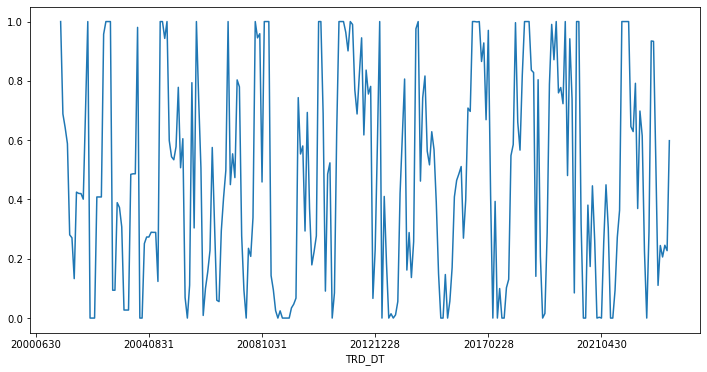

In [31]:
stz_factor_tile_score['Growth'].plot(figsize=(12,6))

<AxesSubplot:xlabel='TRD_DT'>

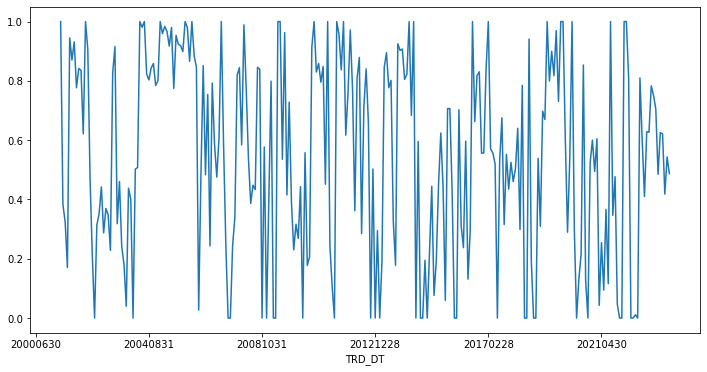

In [32]:
stz_factor_tile_score['Value'].plot(figsize=(12,6))

## 일별 데이터로 확장

### 일별 데이터 불러오기

In [33]:
sql_date = '''  select DT as ScoreDate, YMD as TRD_DT_, MN_END_YN
                from 
                where 1=1
                    and TRADE_YN = 1
                    and YMD >= '20000131'   '''

df_date = pd.read_sql(sql_date, conn_wisefn)

In [34]:
df_date['TRD_DT'] = df_date['TRD_DT_']

for i in range(len(df_date)):
    if df_date['MN_END_YN'][i] == '1' :
        pass
    else:
        df_date['TRD_DT'][i] = df_date['TRD_DT'][i-1]

df_date['TRD_DT'] = df_date['TRD_DT'].shift(1)

<ipython-input-34-7d079e5fbff1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date['TRD_DT'][i] = df_date['TRD_DT'][i-1]


### 일자, 종목별 Factor Tile 월간 데이터를 일간 데이터로 확장

In [35]:
# pd.merge(df_date, ksp200_style_tile_, 'left', 'TRD_DT').head(300).to_csv('.csv')

In [36]:
df_daily = pd.merge(df_date, ksp200_style_tile_, 'left', 'TRD_DT')
# df_daily.fillna(method='ffill', inplace = True)
df_daily = df_daily.iloc[:,1:]
df_daily = df_daily.rename(columns = {'ScoreDate_y':'ScoreDate'})
df_daily.dropna(inplace=True)

In [37]:
df_daily.tail(10)

,TRD_DT_,MN_END_YN,TRD_DT,ScoreDate,Code,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value
1177385,20231130,1,20231031,2023-10-31,A329180,3.0,0.0,2.0,3.0,1.0,2.0,2.0,1.0
1177386,20231130,1,20231031,2023-10-31,A336260,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
1177387,20231130,1,20231031,2023-10-31,A352820,2.0,0.0,3.0,2.0,2.0,3.0,3.0,1.0
1177388,20231130,1,20231031,2023-10-31,A361610,3.0,0.0,3.0,3.0,0.0,2.0,1.0,1.0
1177389,20231130,1,20231031,2023-10-31,A373220,3.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0
1177390,20231130,1,20231031,2023-10-31,A375500,1.0,3.0,1.0,0.0,1.0,2.0,3.0,3.0
1177391,20231130,1,20231031,2023-10-31,A377300,3.0,0.0,2.0,3.0,0.0,2.0,0.0,1.0
1177392,20231130,1,20231031,2023-10-31,A381970,0.0,2.0,1.0,3.0,3.0,0.0,0.0,0.0
1177393,20231130,1,20231031,2023-10-31,A383220,2.0,1.0,0.0,3.0,3.0,2.0,0.0,1.0
1177394,20231130,1,20231031,2023-10-31,A402340,3.0,1.0,2.0,1.0,3.0,3.0,3.0,1.0


#### Factor tile별 Score을 일간 데이터로 확장

In [38]:
df_daily_score = pd.merge(df_date, stz_factor_tile_score, 'left', 'TRD_DT')
df_daily_score = df_daily_score.iloc[:,1:]
df_daily_score = df_daily_score.rename(columns = {'ScoreDate_y':'ScoreDate'})
df_daily_score.dropna(inplace=True)

In [39]:
df_daily_score

,TRD_DT_,MN_END_YN,TRD_DT,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value
324,20010601,0,20010531,1.000000,0.782855,0.487937,0.672897,0.428367,0.899969,1.000000,1.000000
325,20010604,0,20010531,1.000000,0.782855,0.487937,0.672897,0.428367,0.899969,1.000000,1.000000
326,20010605,0,20010531,1.000000,0.782855,0.487937,0.672897,0.428367,0.899969,1.000000,1.000000
327,20010607,0,20010531,1.000000,0.782855,0.487937,0.672897,0.428367,0.899969,1.000000,1.000000
328,20010608,0,20010531,1.000000,0.782855,0.487937,0.672897,0.428367,0.899969,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
5880,20231124,0,20231031,0.598306,0.711331,0.358917,0.946310,1.000000,0.552763,0.748252,0.487201
5881,20231127,0,20231031,0.598306,0.711331,0.358917,0.946310,1.000000,0.552763,0.748252,0.487201
5882,20231128,0,20231031,0.598306,0.711331,0.358917,0.946310,1.000000,0.552763,0.748252,0.487201
5883,20231129,0,20231031,0.598306,0.711331,0.358917,0.946310,1.000000,0.552763,0.748252,0.487201


### stock returns (daily)

In [127]:
sql_price = f'''  select TRD_DT as TRD_DT_, 'A'+STK_CD as Code, VAL
                    from 
                    where 1=1
                        and ITEM_CD = '100300'
                        and STK_CD in {tuple([x[1:] for x in stk_unique_list])}
                        and TRD_DT >= '20000131'  '''

In [128]:
stk_prc = pd.read_sql(sql_price, conn_wisefn)

In [129]:
stk_prc = stk_prc.sort_values(by=['TRD_DT'])
stk_prc['next_prc'] = stk_prc.groupby('Code')['VAL'].shift(-1)
stk_prc['fwd_rt'] = stk_prc['next_prc'] / stk_prc['VAL'] - 1

In [40]:
# stk_prc.to_csv('.csv')
stk_prc = pd.read_csv('.csv')

In [41]:
stk_prc = stk_prc.iloc[:,1:]
stk_prc['TRD_DT'] = stk_prc['TRD_DT'].astype(str)

In [42]:
stk_prc = stk_prc.rename(columns={'TRD_DT':'TRD_DT_'})

In [43]:
ksp200_style_score_fwd_rt = pd.merge(df_daily, stk_prc[['TRD_DT_','Code','fwd_rt']], 'left', ['TRD_DT_','Code'])

In [44]:
ksp200_style_score_fwd_rt[ksp200_style_score_fwd_rt['Code']=='A005930']

,TRD_DT_,MN_END_YN,TRD_DT,ScoreDate,Code,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value,fwd_rt
85,20000703,0,20000630,2000-06-30,A005930,3.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,-0.020000
285,20000704,0,20000630,2000-06-30,A005930,3.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,0.010884
485,20000705,0,20000630,2000-06-30,A005930,3.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,-0.017497
685,20000706,0,20000630,2000-06-30,A005930,3.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,0.008219
885,20000707,0,20000630,2000-06-30,A005930,3.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,0.032609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156239,20231124,0,20231031,2023-10-31,A005930,2.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,NaN
1156439,20231127,0,20231031,2023-10-31,A005930,2.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,NaN
1156639,20231128,0,20231031,2023-10-31,A005930,2.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,NaN
1156839,20231129,0,20231031,2023-10-31,A005930,2.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,NaN


In [45]:
# EW

Growth = pd.DataFrame(ksp200_style_score_fwd_rt.groupby(['TRD_DT_','Growth'])['fwd_rt'].mean())
Market = pd.DataFrame(ksp200_style_score_fwd_rt.groupby(['TRD_DT_','Market'])['fwd_rt'].mean())
Price_mmt = pd.DataFrame(ksp200_style_score_fwd_rt.groupby(['TRD_DT_','Price Momentum'])['fwd_rt'].mean())
Profitability = pd.DataFrame(ksp200_style_score_fwd_rt.groupby(['TRD_DT_','Profitability'])['fwd_rt'].mean())
Sentiment = pd.DataFrame(ksp200_style_score_fwd_rt.groupby(['TRD_DT_','Sentiment'])['fwd_rt'].mean())
Stability = pd.DataFrame(ksp200_style_score_fwd_rt.groupby(['TRD_DT_','Stability'])['fwd_rt'].mean())
value = pd.DataFrame(ksp200_style_score_fwd_rt.groupby(['TRD_DT_','Value'])['fwd_rt'].mean())

In [46]:
grouped_factors_tiles = pd.concat([Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value],axis=1)

In [47]:
Growth1 = pd.pivot(Growth.reset_index(), 'TRD_DT_', 'Growth', 'fwd_rt')
Market1 = pd.pivot(Market.reset_index(), 'TRD_DT_', 'Market', 'fwd_rt')
Price_mmt1 = pd.pivot(Price_mmt.reset_index(), 'TRD_DT_', 'Price Momentum', 'fwd_rt')
Profitability1 = pd.pivot(Profitability.reset_index(), 'TRD_DT_', 'Profitability', 'fwd_rt')
Sentiment1 = pd.pivot(Sentiment.reset_index(), 'TRD_DT_', 'Sentiment', 'fwd_rt')
Stability1 = pd.pivot(Stability.reset_index(), 'TRD_DT_', 'Stability', 'fwd_rt')
value1 = pd.pivot(value.reset_index(), 'TRD_DT_', 'Value', 'fwd_rt')

In [48]:
Market1.dropna()

Market,0.0,1.0,2.0,3.0
TRD_DT_,,,,
20000703,-0.031040,-0.011949,-0.015009,-0.009908
20000704,0.018560,0.005243,0.008851,0.005340
20000705,0.028532,0.019260,0.039608,0.030575
20000706,0.025069,0.025324,0.019009,0.027725
20000707,0.042644,0.009341,0.001416,0.008526
...,...,...,...,...
20231031,0.007213,0.008699,0.008063,0.013738
20231101,0.031022,0.017544,-0.000020,-0.007107
20231102,0.020293,0.014735,0.011897,0.010020


In [49]:
adjusted_factors = pd.DataFrame({'Growth':Growth1[3]-Growth1[0],
                                 'Market':Market1[3]-Market1[0],
                                 'Price_mmt':Price_mmt1[3]-Price_mmt1[0],
                                 'Profitability':Profitability1[3]-Profitability1[0],
                                 'Sentiment':Sentiment1[3]-Sentiment1[0],
                                 'Stability':Stability1[3]-Stability1[0],
                                 'value':value1[3]-value1[0] })

adjusted_factors.index = adjusted_factors.index.astype(str)
adjusted_factors.index = pd.to_datetime(adjusted_factors.index)

# adjusted_factors = adjusted_factors['2004-05-30':]

In [50]:
adjusted_factors.dropna()

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
TRD_DT_,,,,,,,
2000-07-03,-0.001697,0.021131,0.003600,0.008597,0.005079,0.003617,0.007060
2000-07-04,0.012270,-0.013220,0.005735,-0.001328,-0.001912,-0.009256,-0.013023
2000-07-05,-0.001776,0.002043,-0.027492,-0.008068,0.013243,-0.001547,0.022664
2000-07-06,-0.015017,0.002655,-0.034153,-0.007418,-0.017000,0.009929,0.035548
2000-07-07,0.031572,-0.034118,-0.001300,-0.026241,-0.009004,-0.007966,-0.009818
...,...,...,...,...,...,...,...
2023-10-31,-0.007807,0.006524,0.002188,0.008724,0.004687,-0.008582,-0.004990
2023-11-01,0.014335,-0.038129,0.001358,-0.005678,-0.009445,0.000405,-0.000868
2023-11-02,0.005861,-0.010273,-0.001652,-0.010671,-0.013436,-0.004046,0.000751


<AxesSubplot:xlabel='TRD_DT_'>

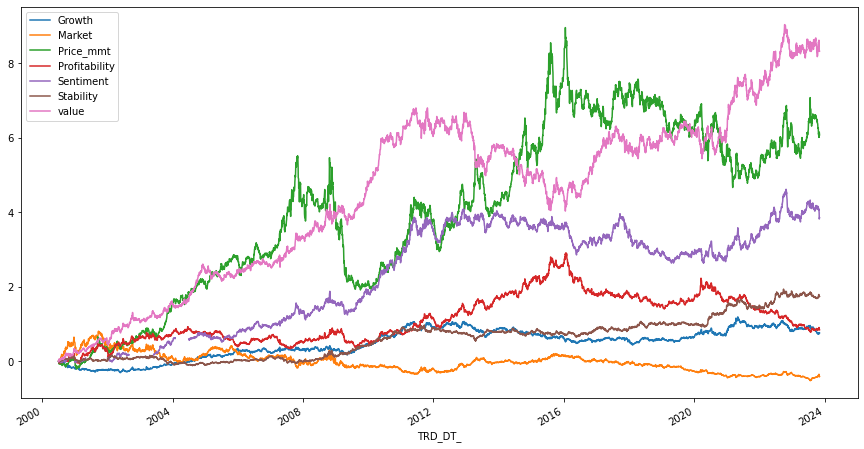

In [51]:
((1+adjusted_factors).cumprod()-1).plot(figsize=(15,8))

In [2]:
# 임시로 데이터 저장함
#adjusted_factors.to_csv('.csv')
adjusted_factors = pd.read_csv('.csv')
adjusted_factors.set_index('TRD_DT_',drop=True,inplace=True)

##### 향후 20일 수익률에 대해서도 계산

In [52]:
stk_prc_20 = stk_prc.copy()
stk_prc_20['next_prc'] = stk_prc_20.groupby('Code')['VAL'].shift(-20)
stk_prc_20['fwd_rt'] = stk_prc_20['next_prc'] / stk_prc_20['VAL'] - 1

In [53]:
stk_prc_20.dropna()

,TRD_DT_,Code,VAL,next_prc,fwd_rt
0,20000131,A000970,1825.68998,1850.69943,0.013699
1,20000131,A000720,283203.64195,208564.92510,-0.263551
2,20000131,A008000,65567.79018,50975.83688,-0.222548
3,20000131,A001040,84720.92286,73177.19522,-0.136256
4,20000131,A001780,895.00000,725.00000,-0.189944
...,...,...,...,...,...
2286561,20231010,A128940,318500.00000,300000.00000,-0.058085
2286562,20231010,A006280,107900.00000,101800.00000,-0.056534
2286563,20231010,A042660,28650.00000,26300.00000,-0.082024
2286564,20231010,A001060,36650.00000,26450.00000,-0.278308


In [54]:
ksp200_style_score_fwd_rt_20 = pd.merge(df_daily, stk_prc_20[['TRD_DT_','Code','fwd_rt']], 'left', ['TRD_DT_','Code'])

# EW

Growth_20 = pd.DataFrame(ksp200_style_score_fwd_rt_20.groupby(['TRD_DT_','Growth'])['fwd_rt'].mean())
Market_20 = pd.DataFrame(ksp200_style_score_fwd_rt_20.groupby(['TRD_DT_','Market'])['fwd_rt'].mean())
Price_mmt_20 = pd.DataFrame(ksp200_style_score_fwd_rt_20.groupby(['TRD_DT_','Price Momentum'])['fwd_rt'].mean())
Profitability_20 = pd.DataFrame(ksp200_style_score_fwd_rt_20.groupby(['TRD_DT_','Profitability'])['fwd_rt'].mean())
Sentiment_20 = pd.DataFrame(ksp200_style_score_fwd_rt_20.groupby(['TRD_DT_','Sentiment'])['fwd_rt'].mean())
Stability_20 = pd.DataFrame(ksp200_style_score_fwd_rt_20.groupby(['TRD_DT_','Stability'])['fwd_rt'].mean())
value_20 = pd.DataFrame(ksp200_style_score_fwd_rt_20.groupby(['TRD_DT_','Value'])['fwd_rt'].mean())

grouped_factors_tiles = pd.concat([Growth_20, Market_20, Price_mmt_20, Profitability_20, Sentiment_20, Stability_20, value_20],axis=1)

Growth1_20 = pd.pivot(Growth_20.reset_index(), 'TRD_DT_', 'Growth', 'fwd_rt')
Market1_20 = pd.pivot(Market_20.reset_index(), 'TRD_DT_', 'Market', 'fwd_rt')
Price_mmt1_20 = pd.pivot(Price_mmt_20.reset_index(), 'TRD_DT_', 'Price Momentum', 'fwd_rt')
Profitability1_20 = pd.pivot(Profitability_20.reset_index(), 'TRD_DT_', 'Profitability', 'fwd_rt')
Sentiment1_20 = pd.pivot(Sentiment_20.reset_index(), 'TRD_DT_', 'Sentiment', 'fwd_rt')
Stability1_20 = pd.pivot(Stability_20.reset_index(), 'TRD_DT_', 'Stability', 'fwd_rt')
value1_20 = pd.pivot(value_20.reset_index(), 'TRD_DT_', 'Value', 'fwd_rt')


adjusted_factors_20 = pd.DataFrame({'Growth':Growth1_20[3]-Growth1_20[0],
                                 'Market':Market1_20[3]-Market1_20[0],
                                 'Price_mmt':Price_mmt1_20[3]-Price_mmt1_20[0],
                                 'Profitability':Profitability1_20[3]-Profitability1_20[0],
                                 'Sentiment':Sentiment1_20[3]-Sentiment1_20[0],
                                 'Stability':Stability1_20[3]-Stability1_20[0],
                                 'value':value1_20[3]-value1_20[0] })

adjusted_factors_20.index = adjusted_factors_20.index.astype(str)
adjusted_factors_20.index = pd.to_datetime(adjusted_factors_20.index)

In [5]:
#adjusted_factors_20.to_csv('.csv')
adjusted_factors_20 = pd.read_csv('.csv', index_col=0)
adjusted_factors_20.index = pd.to_datetime(adjusted_factors_20.index)

In [6]:
adjusted_factors_20

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
TRD_DT_,,,,,,,
2000-07-03,-0.004691,0.087140,-0.051621,-0.024126,-0.009502,0.016481,0.047982
2000-07-04,-0.013337,0.084021,-0.062485,-0.017870,-0.006983,0.020427,0.040332
2000-07-05,-0.028520,0.092906,-0.073838,-0.012891,0.001084,0.036110,0.059076
2000-07-06,-0.031702,0.094265,-0.052672,-0.010629,-0.006313,0.034985,0.038525
2000-07-07,-0.023081,0.120977,-0.007954,0.005834,0.012146,0.030168,0.002725
...,...,...,...,...,...,...,...
2023-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Macro Data

##### 1) 999_quant에 있는 macro 데이터

In [37]:
import pickle

path_prc = ''
with open(path_prc +'economy_all.pkl', 'rb') as f:
    econ = pickle.load(f)

In [39]:
econ.index = pd.to_datetime(econ.index) # datetime

In [58]:
# econ.to_csv('econ_pkl.csv')
econ = pd.read_csv('econ_pkl.csv')

In [59]:
econ

,date,activeNumber,balanceCurAcc_m,balanceCurAcc_q,balanceCurAcc_y,bnd_10y,bnd_1y,bnd_20y,bnd_30y,bnd_3y,...,priCon_y_qoq,pri_t,sangm_1y,unempNumber,unempR,unempRate_m,unempRate_q,unempRate_y,usd,yen
0,2000-12-26,61.4,0.0,0.0,0.0,7.250,6.660,0.000,0.000,6.750,...,0.00,67.104,6.800,940.0,4.2,0.0,0.0,0.0,1232.1,1089.73
1,2001-01-02,61.3,0.0,0.0,0.0,7.180,6.680,0.000,0.000,6.670,...,0.00,67.370,6.820,977.0,4.4,0.0,0.0,0.0,1259.7,1099.07
2,2001-01-03,61.3,0.0,0.0,0.0,7.150,6.630,0.000,0.000,6.640,...,0.00,67.370,6.750,977.0,4.4,0.0,0.0,0.0,1267.8,1108.07
3,2001-01-04,61.3,0.0,0.0,0.0,6.850,6.380,0.000,0.000,6.370,...,0.00,67.370,6.490,977.0,4.4,0.0,0.0,0.0,1285.4,1128.53
4,2001-01-05,61.3,0.0,0.0,0.0,6.680,6.170,0.000,0.000,6.190,...,0.00,67.370,6.310,977.0,4.4,0.0,0.0,0.0,1249.3,1078.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5642,2023-11-01,64.4,110.0,120.0,300.0,4.288,3.731,4.097,4.020,4.071,...,1.95,NaN,4.110,761.4,2.6,2.9,2.6,2.8,1349.6,892.39
5643,2023-11-02,64.4,110.0,120.0,300.0,4.168,3.687,4.053,4.002,3.979,...,1.95,NaN,4.072,761.4,2.6,2.9,2.6,2.8,1356.9,900.64
5644,2023-11-03,64.4,110.0,120.0,300.0,4.105,3.693,3.997,3.944,3.949,...,1.95,NaN,4.073,761.4,2.6,2.9,2.6,2.8,1343.2,892.67
5645,2023-11-06,64.4,110.0,120.0,300.0,4.056,3.693,3.951,3.905,3.877,...,1.95,NaN,4.066,761.4,2.6,2.9,2.6,2.8,1325.8,887.27


In [60]:
econ.columns

Index(['date', 'activeNumber', 'balanceCurAcc_m', 'balanceCurAcc_q',
       'balanceCurAcc_y', 'bnd_10y', 'bnd_1y', 'bnd_20y', 'bnd_30y', 'bnd_3y',
       'bnd_50y', 'bnd_5y', 'bsi', 'callRate_kr', 'callRate_se',
       'callRate_witoutCol', 'callRate_witoutCol_1d', 'cbnd_3y', 'cbnd_3y_jnk',
       'cd_91d', 'cofix_balance', 'cofix_new', 'cofix_shortTerm', 'const_coop',
       'const_forg', 'const_priv', 'const_pub', 'const_q_qoq', 'const_y_qoq',
       'cp_91d', 'cpi_m_yoy', 'cpi_q_yoy', 'cpi_y_yoy', 'csi', 'defaultN',
       'defaultR_se', 'defaultR_total', 'empR', 'euro', 'export_m_yoy',
       'export_q_yoy', 'export_y_yoy', 'gdp_q_qoq', 'gdp_y_qoq', 'hanjeon_5y',
       'hkd', 'hsePrc', 'hsePrc_6c', 'hsePrc_cap', 'hsePrc_others',
       'hsePrc_se', 'hsePrc_se_north', 'hsePrc_se_south', 'import_m_yoy',
       'import_q_yoy', 'import_y_yoy', 'inactiveNumber', 'kookmin_5y',
       'monStab_1y', 'monStab_2y', 'monStab_91d', 'pi_m_yoy', 'pi_q_yoy',
       'pi_y_yoy', 'plant_q_qoq', 'p

In [61]:
# 국공채 10년물, 3년물, 회사채 3년물, 달러
econ_pick_1 = econ[['date','bnd_10y','bnd_3y','cbnd_3y','usd']]
econ_pick_1 = econ_pick_1.rename(columns={'date':'TRD_DT'})
econ_pick_1['TRD_DT'] = pd.to_datetime(econ_pick_1['TRD_DT'])

In [62]:
type(econ_pick_1['TRD_DT'][0])

pandas._libs.tslibs.timestamps.Timestamp

##### 2) wisefn DB 자료 : 코스피 지수

In [63]:
sql_mkt = '''   select TRD_DT, CLOSE_PRC
                from 
                where 1=1
                    and SEC_CD = 'IKS001'
                    and TRD_DT > '20030101'
                order by TRD_DT  '''

econ_mkt = pd.read_sql(sql_mkt, conn_wisefn)

In [64]:
econ_mkt.set_index('TRD_DT',drop=True, inplace=True)
econ_mkt['rtn'] = econ_mkt.pct_change(1)
econ_mkt['vol'] = econ_mkt['rtn'].rolling(120).std()

In [65]:
econ_mkt.reset_index(inplace=True)
econ_pick_2 = econ_mkt[['TRD_DT','CLOSE_PRC','vol']]

In [66]:
econ_pick_2['TRD_DT'] = pd.to_datetime(econ_pick_2['TRD_DT'])

<ipython-input-66-8380010eb9f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_pick_2['TRD_DT'] = pd.to_datetime(econ_pick_2['TRD_DT'])


In [67]:
type(econ_pick_2['TRD_DT'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [68]:
econ_pick_sum = pd.merge(econ_pick_2, econ_pick_1, 'left', 'TRD_DT')
econ_pick_sum['TRD_DT_'] = econ_pick_sum['TRD_DT'].dt.strftime('%Y%m%d')
econ_pick_sum = econ_pick_sum.rename(columns={'CLOSE_PRC':'kospi'})

In [69]:
econ_pick_sum = econ_pick_sum.dropna()

In [70]:
econ_pick_sum[econ_pick_sum['TRD_DT']>'2022-03-15']

,TRD_DT,kospi,vol,bnd_10y,bnd_3y,cbnd_3y,usd,TRD_DT_
4748,2022-03-16,2659.23,0.011022,2.768,2.268,2.948,1241.7,20220316
4749,2022-03-17,2694.51,0.011100,2.704,2.217,2.902,1240.4,20220317
4750,2022-03-18,2707.02,0.011098,2.737,2.231,2.911,1220.6,20220318
4751,2022-03-21,2686.05,0.011107,2.741,2.268,2.944,1211.1,20220321
4753,2022-03-23,2735.05,0.011182,2.828,2.426,3.073,1221.4,20220323
...,...,...,...,...,...,...,...,...
5151,2023-11-01,2301.56,0.008677,4.288,4.071,4.900,1349.6,20231101
5152,2023-11-02,2343.12,0.008829,4.168,3.979,4.811,1356.9,20231102
5153,2023-11-03,2368.34,0.008889,4.105,3.949,4.789,1343.2,20231103
5154,2023-11-06,2502.37,0.010290,4.056,3.877,4.721,1325.8,20231106


#### 3) MinMaxScaler 적용 : 250일(1년) rolling하여 0~1 사이의 값으로 변형

In [71]:
econ_pick_sum.set_index(['TRD_DT','TRD_DT_'],inplace=True,drop=True)

In [72]:
econ_pick_sum_scaled = econ_pick_sum.copy()
econ_pick_sum_scaled = econ_pick_sum_scaled.apply(lambda x: min_max(x,250)) # 1년

In [73]:
econ_pick_sum_scaled.reset_index(inplace=True)

In [74]:
# 금리의 경우, term spread, credit spread 로 변형하여 반영
econ_pick_sum_scaled['term_spread'] = econ_pick_sum_scaled['bnd_10y'] - econ_pick_sum_scaled['bnd_3y']
econ_pick_sum_scaled['credit_spread'] = econ_pick_sum_scaled['cbnd_3y'] - econ_pick_sum_scaled['bnd_3y']
econ_pick_sum_scaled = econ_pick_sum_scaled[['TRD_DT','TRD_DT_','kospi','vol','bnd_10y','usd','term_spread','credit_spread']]

In [75]:
econ_pick_sum_scaled.iloc[:,2:] = econ_pick_sum_scaled.iloc[:,2:].shift(1)

In [76]:
econ_pick_sum_scaled.tail(10)

,TRD_DT,TRD_DT_,kospi,vol,bnd_10y,usd,term_spread,credit_spread
5025,2023-10-25,20231025,0.375350,0.191315,0.755391,0.616199,0.109903,-0.080638
5026,2023-10-26,20231026,0.330543,0.197487,0.763477,0.573401,0.093441,-0.089209
5027,2023-10-27,20231027,0.179308,0.260841,0.918081,0.587667,0.086282,-0.199861
5028,2023-10-30,20231030,0.187627,0.260524,0.909968,0.634146,0.068185,-0.220556
5029,2023-10-31,20231031,0.204889,0.253234,0.935691,0.612339,0.079922,-0.224318
5030,2023-11-01,20231101,0.132273,0.263104,0.946141,0.639062,0.093869,-0.219361
5031,2023-11-02,20231102,0.184839,0.274112,0.916399,0.641556,0.023276,-0.264106
5032,2023-11-03,20231103,0.277526,0.302498,0.819936,0.677499,0.012315,-0.221934
5033,2023-11-06,20231106,0.333772,0.313635,0.769293,0.610044,-0.010447,-0.204764
5034,2023-11-07,20231107,0.632686,0.574288,0.729904,0.524372,0.017078,-0.170956


### Factor Score + Econ data 합치기

In [77]:
train_data_source = pd.merge(df_daily_score, econ_pick_sum_scaled.iloc[:,1:] ,'left','TRD_DT_').dropna()

In [78]:
train_data_source

,TRD_DT_,MN_END_YN,TRD_DT,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value,kospi,vol,bnd_10y,usd,term_spread,credit_spread
758,20040705,0,20040630,0.251232,0.778566,0.800296,0.90949,0.50143,0.389534,0.268290,1.000000,0.321234,0.732957,0.405941,0.204762,0.165200,-0.224074
759,20040706,0,20040630,0.251232,0.778566,0.800296,0.90949,0.50143,0.389534,0.268290,1.000000,0.326119,0.767938,0.356436,0.241270,0.143473,-0.212963
760,20040707,0,20040630,0.251232,0.778566,0.800296,0.90949,0.50143,0.389534,0.268290,1.000000,0.332695,0.767921,0.356436,0.193651,0.143473,-0.212963
761,20040708,0,20040630,0.251232,0.778566,0.800296,0.90949,0.50143,0.389534,0.268290,1.000000,0.333435,0.749525,0.346535,0.225397,0.142831,-0.203704
762,20040709,0,20040630,0.251232,0.778566,0.800296,0.90949,0.50143,0.389534,0.268290,1.000000,0.231120,0.766202,0.376238,0.209524,0.144756,-0.207091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,20231101,0,20231031,0.598306,0.711331,0.358917,0.94631,1.00000,0.552763,0.748252,0.487201,0.132273,0.263104,0.946141,0.639062,0.093869,-0.219361
5540,20231102,0,20231031,0.598306,0.711331,0.358917,0.94631,1.00000,0.552763,0.748252,0.487201,0.184839,0.274112,0.916399,0.641556,0.023276,-0.264106
5541,20231103,0,20231031,0.598306,0.711331,0.358917,0.94631,1.00000,0.552763,0.748252,0.487201,0.277526,0.302498,0.819936,0.677499,0.012315,-0.221934
5542,20231106,0,20231031,0.598306,0.711331,0.358917,0.94631,1.00000,0.552763,0.748252,0.487201,0.333772,0.313635,0.769293,0.610044,-0.010447,-0.204764


In [7]:
#train_data_source.to_csv('train_data_source.csv')
train_data_source = pd.read_csv('train_data_source.csv')
train_data_source = train_data_source.iloc[:,1:]

In [8]:
#train_data_source.set_index('TRD_DT_',drop=True,inplace=True)
train_data_source['TRD_DT_'] = pd.to_datetime(train_data_source['TRD_DT_'], format="%Y%m%d")

In [9]:
# train_data_source.reset_index(drop=True, inplace=True)
# train_data_source['MN_ST_YN'] = train_data_source['MN_END_YN'].shift(1)

In [10]:
train_data_source[train_data_source['TRD_DT_'] > '2022-03-25'].head(10)

,TRD_DT_,MN_END_YN,TRD_DT,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value,kospi,vol,bnd_10y,usd,term_spread,credit_spread
4385,2022-03-28,0,20220228,1.0,0.675412,0.542922,0.948339,1.000000,0.0,0.984201,1.0,0.167202,0.642876,1.000000,0.834447,0.000000,0.000000
4386,2022-03-29,0,20220228,1.0,0.675412,0.542922,0.948339,1.000000,0.0,0.984201,1.0,0.166594,0.652068,1.000000,0.826281,0.000000,0.000000
4387,2022-03-30,0,20220228,1.0,0.675412,0.542922,0.948339,1.000000,0.0,0.984201,1.0,0.183258,0.652863,0.949915,0.881218,-0.021737,0.007774
4388,2022-03-31,1,20220228,1.0,0.675412,0.542922,0.948339,1.000000,0.0,0.984201,1.0,0.191467,0.664331,0.876061,0.842613,-0.044325,0.015400
4389,2022-04-01,0,20220331,1.0,0.470068,0.250894,0.770333,0.986772,0.0,0.990172,1.0,0.207262,0.643403,0.947368,0.770601,-0.001784,0.017182
4390,2022-04-04,0,20220331,1.0,0.470068,0.250894,0.770333,0.986772,0.0,0.990172,1.0,0.181492,0.626477,0.979626,0.769859,-0.020374,0.000000
4391,2022-04-05,0,20220331,1.0,0.470068,0.250894,0.770333,0.986772,0.0,0.990172,1.0,0.207624,0.607475,1.000000,0.809948,0.000000,0.000000
4392,2022-04-06,0,20220331,1.0,0.470068,0.250894,0.770333,0.986772,0.0,0.990172,1.0,0.209506,0.609228,1.000000,0.814402,0.000000,0.000000
4393,2022-04-07,0,20220331,1.0,0.470068,0.250894,0.770333,0.986772,0.0,0.990172,1.0,0.174514,0.602230,1.000000,0.783964,0.000000,0.000000
4394,2022-04-08,0,20220331,1.0,0.470068,0.250894,0.770333,0.986772,0.0,0.990172,1.0,0.117805,0.608421,0.999216,0.832220,0.018718,0.002853


In [11]:
train_data_source.iloc[20,0]

Timestamp('2004-08-02 00:00:00')

### 팩터 일별 지수화 (불필요)

In [6]:
adjusted_factors_idx = adjusted_factors.copy()

In [7]:
adjusted_factors_idx = adjusted_factors_idx.shift(-1)
adjusted_factors_idx.dropna(inplace=True)
#adjusted_factors_idx = adjusted_factors_idx.fillna(0)

In [8]:
adjusted_factors_idx

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
TRD_DT_,,,,,,,
2000-07-03,0.012270,-0.013220,0.005735,-0.001328,-0.001912,-0.009256,-0.013023
2000-07-04,-0.001776,0.002043,-0.027492,-0.008068,0.013243,-0.001547,0.022664
2000-07-05,-0.015017,0.002655,-0.034153,-0.007418,-0.017000,0.009929,0.035548
2000-07-06,0.031572,-0.034118,-0.001300,-0.026241,-0.009004,-0.007966,-0.009818
2000-07-07,-0.020982,0.005025,-0.022502,-0.008608,-0.014036,-0.013389,0.021321
...,...,...,...,...,...,...,...
2023-10-30,-0.007807,0.006524,0.002188,0.008724,0.004687,-0.008582,-0.004990
2023-10-31,0.014335,-0.038129,0.001358,-0.005678,-0.009445,0.000405,-0.000868
2023-11-01,0.005861,-0.010273,-0.001652,-0.010671,-0.013436,-0.004046,0.000751


In [9]:
adjusted_factors_idx = (adjusted_factors_idx + 1).cumprod()*100

In [10]:
adjusted_factors_idx

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
TRD_DT_,,,,,,,
2000-07-03,101.227009,98.677954,100.573485,99.867232,99.808756,99.074351,98.697705
2000-07-04,101.047195,98.879549,97.808538,99.061477,101.130525,98.921087,100.934577
2000-07-05,99.529766,99.142108,94.468040,98.326600,99.411308,99.903248,104.522636
2000-07-06,102.672088,95.759559,94.345273,95.746420,98.516243,99.107425,103.496415
2000-07-07,100.517833,96.240744,92.222318,94.922217,97.133432,97.780492,105.703060
...,...,...,...,...,...,...,...
2023-10-30,153.983900,54.791895,347.688369,133.994969,505.725513,274.596002,589.704687
2023-10-31,156.191202,52.702756,348.160678,133.234098,500.949159,274.707316,589.193102
2023-11-01,157.106613,52.161332,347.585479,131.812375,494.218655,273.595873,589.635342


### 향후 20일 수익률

In [12]:
fwd_20d_rt = adjusted_factors_20.dropna()

In [13]:
fwd_20d_rt.index = pd.to_datetime(fwd_20d_rt.index)
#fwd_20d_rt.reset_index(inplace=True)

In [14]:
fwd_20d_rt.dropna()

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
TRD_DT_,,,,,,,
2000-07-03,-0.004691,0.087140,-0.051621,-0.024126,-0.009502,0.016481,0.047982
2000-07-04,-0.013337,0.084021,-0.062485,-0.017870,-0.006983,0.020427,0.040332
2000-07-05,-0.028520,0.092906,-0.073838,-0.012891,0.001084,0.036110,0.059076
2000-07-06,-0.031702,0.094265,-0.052672,-0.010629,-0.006313,0.034985,0.038525
2000-07-07,-0.023081,0.120977,-0.007954,0.005834,0.012146,0.030168,0.002725
...,...,...,...,...,...,...,...
2023-09-27,-0.057257,0.116464,-0.047131,0.017554,-0.011637,-0.016148,0.000248
2023-10-04,-0.024555,0.092668,-0.065814,0.015802,-0.017776,0.027948,0.001604
2023-10-05,-0.018107,0.079242,-0.065841,0.001184,-0.029615,0.019241,0.007785


In [15]:
train_data_source

,TRD_DT_,MN_END_YN,TRD_DT,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value,kospi,vol,bnd_10y,usd,term_spread,credit_spread
0,2004-07-05,0,20040630,0.251232,0.778566,0.800296,0.90949,0.50143,0.389534,0.268290,1.000000,0.321234,0.732957,0.405941,0.204762,0.165200,-0.224074
1,2004-07-06,0,20040630,0.251232,0.778566,0.800296,0.90949,0.50143,0.389534,0.268290,1.000000,0.326119,0.767938,0.356436,0.241270,0.143473,-0.212963
2,2004-07-07,0,20040630,0.251232,0.778566,0.800296,0.90949,0.50143,0.389534,0.268290,1.000000,0.332695,0.767921,0.356436,0.193651,0.143473,-0.212963
3,2004-07-08,0,20040630,0.251232,0.778566,0.800296,0.90949,0.50143,0.389534,0.268290,1.000000,0.333435,0.749525,0.346535,0.225397,0.142831,-0.203704
4,2004-07-09,0,20040630,0.251232,0.778566,0.800296,0.90949,0.50143,0.389534,0.268290,1.000000,0.231120,0.766202,0.376238,0.209524,0.144756,-0.207091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4780,2023-11-01,0,20231031,0.598306,0.711331,0.358917,0.94631,1.00000,0.552763,0.748252,0.487201,0.132273,0.263104,0.946141,0.639062,0.093869,-0.219361
4781,2023-11-02,0,20231031,0.598306,0.711331,0.358917,0.94631,1.00000,0.552763,0.748252,0.487201,0.184839,0.274112,0.916399,0.641556,0.023276,-0.264106
4782,2023-11-03,0,20231031,0.598306,0.711331,0.358917,0.94631,1.00000,0.552763,0.748252,0.487201,0.277526,0.302498,0.819936,0.677499,0.012315,-0.221934
4783,2023-11-06,0,20231031,0.598306,0.711331,0.358917,0.94631,1.00000,0.552763,0.748252,0.487201,0.333772,0.313635,0.769293,0.610044,-0.010447,-0.204764


In [119]:
pd.merge(train_data_source,fwd_20d_rt,'left','TRD_DT_' ).dropna()

,TRD_DT_,MN_END_YN,TRD_DT,Growth_x,Market_x,Price Momentum,Price-reversal,Profitability_x,Sentiment_x,Stability_x,...,usd,term_spread,credit_spread,Growth_y,Market_y,Price_mmt,Profitability_y,Sentiment_y,Stability_y,value
0,2004-07-05,0,20040630,0.251232,0.778566,0.800296,0.909490,0.501430,0.389534,0.268290,...,0.204762,0.165200,-0.224074,0.000857,0.016703,0.044831,-0.030033,0.018797,-0.003431,0.072337
1,2004-07-06,0,20040630,0.251232,0.778566,0.800296,0.909490,0.501430,0.389534,0.268290,...,0.241270,0.143473,-0.212963,0.016817,-0.002093,0.045588,-0.031188,0.030340,-0.009678,0.051192
2,2004-07-07,0,20040630,0.251232,0.778566,0.800296,0.909490,0.501430,0.389534,0.268290,...,0.193651,0.143473,-0.212963,0.025918,-0.001845,0.040274,-0.027391,0.028916,-0.010128,0.038602
3,2004-07-08,0,20040630,0.251232,0.778566,0.800296,0.909490,0.501430,0.389534,0.268290,...,0.225397,0.142831,-0.203704,0.036796,-0.031159,0.043479,-0.030121,0.039932,-0.015420,0.023846
4,2004-07-09,0,20040630,0.251232,0.778566,0.800296,0.909490,0.501430,0.389534,0.268290,...,0.209524,0.144756,-0.207091,0.032532,0.002178,0.038058,-0.033526,0.018115,-0.010186,0.041396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,2023-09-27,1,20230831,0.245530,0.129767,0.000000,0.337332,0.971371,0.857219,0.811943,...,0.526461,0.046613,-0.072358,-0.057257,0.116464,-0.047131,0.017554,-0.011637,-0.016148,0.000248
4761,2023-10-04,0,20230927,0.227338,0.000000,0.163513,0.517198,1.000000,0.952218,0.747977,...,0.577543,0.035495,-0.065424,-0.024555,0.092668,-0.065814,0.015802,-0.017776,0.027948,0.001604
4762,2023-10-05,0,20230927,0.227338,0.000000,0.163513,0.517198,1.000000,0.952218,0.747977,...,0.607455,0.090069,-0.127063,-0.018107,0.079242,-0.065841,0.001184,-0.029615,0.019241,0.007785
4763,2023-10-06,0,20230927,0.227338,0.000000,0.163513,0.517198,1.000000,0.952218,0.747977,...,0.650253,0.090022,-0.115087,-0.008143,0.024421,-0.047129,-0.017149,-0.047579,0.012217,-0.002368


## Train, Test dataset

#### 매 월말 기준으로 3년(750일) rolling dataset 만들기

In [151]:
# 함수

In [16]:
import random

number_of_factors_each = 2

In [ ]:
def invest_point_set(data, filtering = 'end of month'):
    if filtering == 1:
        filtered_df = main_df[main_df['MN_END_YN']==1]
    elif filtering == 2:
        rdnm = random.sample(range(1,len(main_df)),100)
        filtered_df = main_df.iloc[rdnm]
    elif filtering == 'end of month':
        filtered_df = main_df[main_df['MN_END_YN'].shift(1)==1]
    else:
        filtered_df = main_df.copy()
    

In [17]:
def Simulation_data_list(main_df = train_data_source, filtering = 3, fwd_rt_df = fwd_20d_rt, rolling_range = 750):
    '''
    main_df: 기본 학습 데이터셋
    filtering: 1 = 월말로 필터링, 2: random, 3: 월초로 필터링
    rolling_range: moving window 기간
    fwd_rt_df: 향후 수익률
    '''
    
    if filtering == 1:
        filtered_df = main_df[main_df['MN_END_YN']==1]
    elif filtering == 2:
        rdnm = random.sample(range(1,len(main_df)),100)
        filtered_df = main_df.iloc[rdnm]
    elif filtering == 3:
        filtered_df = main_df[main_df['MN_END_YN'].shift(1)==1]
    else:
        filtered_df = main_df.copy()
    
    date_rannge = rolling_range
    
    
    compressed_dfs = []
    for index, row in filtered_df.iterrows():
        start_index = max(0, index - date_rannge)  # 이전 750개 행으로 필터링
        subset_df = train_data_source.iloc[start_index:index + 1]
        compressed_dfs.append( subset_df)
        
    # 롱숏 성과가 0 초과한 경우 1을 부여, 그렇지 않은 경우 0 부여
    fwd_bin = fwd_rt_df.copy()
    fwd_bin = (fwd_bin > 0)*1
    fwd_bin.columns = [name+"_WL" for name in fwd_rt_df.columns]
    fwd_bin.index = pd.to_datetime(fwd_bin.index)
    
    for i in range(len(compressed_dfs)):
        dts = compressed_dfs[i]
        dts = pd.merge(dts, fwd_bin, 'left','TRD_DT_')
        compressed_dfs[i] = dts
    
    data_list = []
    for i in range(len(compressed_dfs)-1):
        if len(compressed_dfs[i]) > date_rannge:
            data_list.append(compressed_dfs[i])
        else:
            pass
    
    return data_list

In [18]:
def simulation_model(data_list, model): 
    
    mid = pd.DataFrame()
    
    for k in range(len(data_list)):
        sub_imsi = data_list[k]

        sub_factors_list = sub_imsi.columns[17:]
        expln_variables_list = sub_imsi.columns[3:17]

        sub_train = sub_imsi.iloc[:-1,:]
        sub_test = sub_imsi.iloc[-1,:]

        prob_sets = []
        for fcts in range(len(sub_factors_list)):
            # train, test dataset
            sub_train_x = sub_train[expln_variables_list]
            sub_train_y = sub_train[sub_factors_list[fcts]]

            sub_test_x = sub_test[expln_variables_list]
            sub_test_y = sub_test[sub_factors_list[fcts]]

            # Statistical_model
            model = model
            model.fit(sub_train_x, sub_train_y)
            model_probabilities = model.predict_proba(sub_test_x.values.reshape(1, -1))
            prob_sets = np.append(prob_sets, model_probabilities)
            
        WL = pd.DataFrame(prob_sets.reshape(7,2), columns=['lose',sub_imsi.iloc[-1,0]],index = [x[:-3] for x in sub_factors_list] )
        win = pd.DataFrame(WL.iloc[:,1]).transpose()    

        mid = pd.concat([mid, win],axis=0)
    
    return mid

In [19]:
def simulation_performace_graph(data, number_of_factors_each = number_of_factors_each):
    mid2 = data.copy()
    mid2_rnk = mid2.rank(axis=1, ascending=False)

    long_sgn2 = (mid2_rnk < (number_of_factors_each + 1))*1
    long_sgn2 = long_sgn2.replace(0,np.NaN)

    short_sgn2 = (mid2_rnk > (len(mid2_rnk.columns)-number_of_factors_each))*1
    short_sgn2 = short_sgn2.replace(0,np.NaN)

    long_rtn2 = long_sgn2*fwd_20d_rt[fwd_20d_rt.index.isin(mid2.index)]
    short_rtn2 = short_sgn2*fwd_20d_rt[fwd_20d_rt.index.isin(mid2.index)]

    long_short_rtn2 = pd.DataFrame({'long_fwd_rtn':long_rtn2.mean(axis=1), 'short_fwd_rtn':short_rtn2.mean(axis=1),
                                  'LS':long_rtn2.mean(axis=1) - short_rtn2.mean(axis=1)})
    
    return long_short_rtn2

In [20]:
# 월초
data_list = Simulation_data_list(filtering = 3)

In [22]:
data_list[100]

,TRD_DT_,MN_END_YN,TRD_DT,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,...,usd,term_spread,credit_spread,Growth_WL,Market_WL,Price_mmt_WL,Profitability_WL,Sentiment_WL,Stability_WL,value_WL
0,2012-11-14,0,20121031,0.781360,0.000000,0.462759,0.550332,0.073549,0.690251,1.000000,...,0.013728,-0.032165,-0.017418,1,0,0,0,1,1,1
1,2012-11-15,0,20121031,0.781360,0.000000,0.462759,0.550332,0.073549,0.690251,1.000000,...,0.033791,-0.034297,-0.019906,1,0,0,0,0,1,1
2,2012-11-16,0,20121031,0.781360,0.000000,0.462759,0.550332,0.073549,0.690251,1.000000,...,0.002112,-0.023545,-0.009153,1,0,0,0,0,1,1
3,2012-11-19,0,20121031,0.781360,0.000000,0.462759,0.550332,0.073549,0.690251,1.000000,...,0.000000,-0.021413,-0.006665,1,0,0,0,0,1,1
4,2012-11-20,0,20121031,0.781360,0.000000,0.462759,0.550332,0.073549,0.690251,1.000000,...,0.027340,-0.025677,-0.011641,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,2015-11-25,0,20151030,0.170283,0.406713,0.401748,0.892225,1.000000,0.664703,0.652399,...,0.665185,0.012272,0.100483,0,1,1,1,1,0,0
747,2015-11-26,0,20151030,0.170283,0.406713,0.401748,0.892225,1.000000,0.664703,0.652399,...,0.648148,-0.028867,0.100632,0,1,1,1,0,0,0
748,2015-11-27,0,20151030,0.170283,0.406713,0.401748,0.892225,1.000000,0.664703,0.652399,...,0.570370,-0.057171,0.102920,0,1,1,0,0,0,0
749,2015-11-30,1,20151030,0.170283,0.406713,0.401748,0.892225,1.000000,0.664703,0.652399,...,0.574815,-0.045992,0.107644,0,0,1,1,0,0,0


In [23]:
data_list[101]

,TRD_DT_,MN_END_YN,TRD_DT,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,...,usd,term_spread,credit_spread,Growth_WL,Market_WL,Price_mmt_WL,Profitability_WL,Sentiment_WL,Stability_WL,value_WL
0,2012-12-13,0,20121130,0.066372,0.000000,0.770914,0.285224,0.010725,0.740433,1.000000,...,0.000000,0.034761,-0.095974,0,1,1,0,0,0,0
1,2012-12-14,0,20121130,0.066372,0.000000,0.770914,0.285224,0.010725,0.740433,1.000000,...,0.000000,0.036986,-0.103439,0,1,1,1,0,0,0
2,2012-12-17,0,20121130,0.066372,0.000000,0.770914,0.285224,0.010725,0.740433,1.000000,...,0.000000,0.034854,-0.105927,0,1,1,1,0,0,0
3,2012-12-18,0,20121130,0.066372,0.000000,0.770914,0.285224,0.010725,0.740433,1.000000,...,0.014612,0.032722,-0.116680,0,1,1,0,0,0,0
4,2012-12-20,0,20121130,0.066372,0.000000,0.770914,0.285224,0.010725,0.740433,1.000000,...,0.005479,0.037078,-0.121656,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,2015-12-24,0,20151130,0.408649,0.101032,0.033905,0.477427,1.000000,0.167605,0.519184,...,0.800000,-0.046657,0.211952,0,0,1,1,0,0,0
747,2015-12-28,0,20151130,0.408649,0.101032,0.033905,0.477427,1.000000,0.167605,0.519184,...,0.767407,-0.055385,0.216967,0,0,1,1,1,0,0
748,2015-12-29,0,20151130,0.408649,0.101032,0.033905,0.477427,1.000000,0.167605,0.519184,...,0.762222,-0.086989,0.207007,0,0,1,1,1,0,0
749,2015-12-30,1,20151130,0.408649,0.101032,0.033905,0.477427,1.000000,0.167605,0.519184,...,0.717778,-0.092970,0.218522,0,0,1,1,1,0,0


### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
mid11 = simulation_model(data_list, model = LogisticRegression())
graph11 = simulation_performace_graph(mid11)

0.6358974358974359

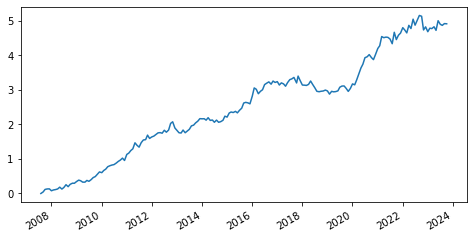

In [25]:
((graph11['long_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph11['long_fwd_rtn'] > 0)*1) / len(graph11)

0.5846153846153846

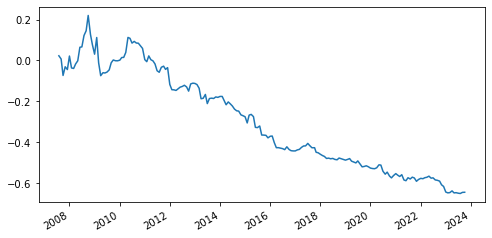

In [26]:
((graph11['short_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph11['short_fwd_rtn']< 0)*1) / len(graph11)

In [27]:
mid11['2022':]

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
2022-01-03,0.683332,0.491768,0.330702,0.222381,0.693212,0.461915,0.704374
2022-02-03,0.479371,0.874566,0.323114,0.394580,0.692669,0.460477,0.512529
2022-03-02,0.898361,0.423227,0.683764,0.798162,0.925990,0.632322,0.742213
2022-04-01,0.623316,0.792732,0.471541,0.659128,0.753075,0.225460,0.634011
2022-05-02,0.282398,0.844556,0.773039,0.042789,0.708496,0.911817,0.829540
2022-06-02,0.177295,0.520726,0.584222,0.008885,0.216962,0.926976,0.437300
2022-07-01,0.078978,0.522613,0.407204,0.176791,0.231378,0.946811,0.219192
2022-08-01,0.458638,0.273678,0.700063,0.177212,0.563676,0.837723,0.600666
2022-09-01,0.398715,0.451191,0.436133,0.122165,0.472452,0.915163,0.523870
2022-10-04,0.218169,0.479222,0.495223,0.465758,0.512085,0.878318,0.725884


### XGBoost

In [28]:
from xgboost import XGBClassifier
mid22 = simulation_model(data_list, model = XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3))
graph2 = simulation_performace_graph(mid22)

0.8

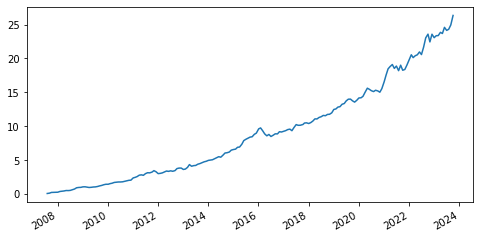

In [29]:
((graph2['long_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph2['long_fwd_rtn'] > 0)*1) / len(graph2)

0.6564102564102564

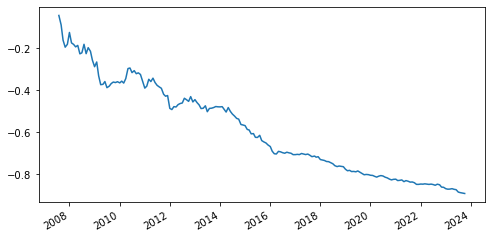

In [32]:
((graph2['short_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph2['short_fwd_rtn']< 0)*1) / len(graph2)

In [33]:
mid22

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
2007-08-01,0.555570,0.218124,0.850633,0.769038,0.745546,0.468883,0.765612
2007-09-03,0.776729,0.050489,0.974908,0.815826,0.940653,0.497436,0.987100
2007-10-01,0.553984,0.099104,0.986908,0.848457,0.823934,0.619448,0.591443
2007-11-01,0.327626,0.667664,0.759051,0.915264,0.384304,0.851264,0.926459
2007-12-03,0.542216,0.226720,0.368301,0.156822,0.644675,0.232447,0.953368
...,...,...,...,...,...,...,...
2023-06-01,0.713977,0.317990,0.614829,0.075818,0.849745,0.409707,0.370287
2023-07-03,0.503728,0.199857,0.704172,0.116328,0.893938,0.361505,0.772983
2023-08-01,0.799629,0.542114,0.420400,0.650534,0.478056,0.122346,0.722437
2023-09-01,0.125037,0.539017,0.488720,0.290640,0.194160,0.297022,0.367400


### Support Vector Machine

In [34]:
from sklearn.svm import SVC
mid33 = simulation_model(data_list, model = SVC(probability=True))
graph3 = simulation_performace_graph(mid33)

0.7282051282051282

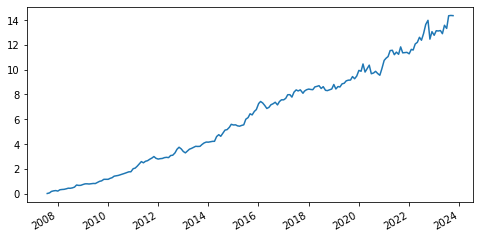

In [35]:
((graph3['long_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph3['long_fwd_rtn'] > 0)*1) / len(graph3)

0.5897435897435898

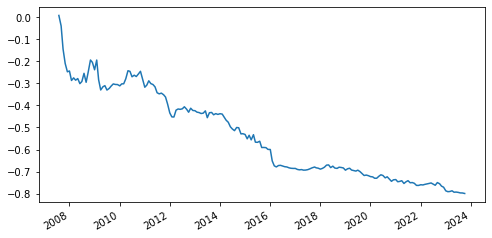

In [36]:
((graph3['short_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph3['short_fwd_rtn']< 0)*1) / len(graph3)

In [37]:
mid33

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
2007-08-01,0.442278,0.728305,0.888407,0.408045,0.500000,0.456162,0.681465
2007-09-03,0.530210,0.179739,0.975960,0.642809,0.924654,0.201461,0.971334
2007-10-01,0.683950,0.516027,0.969007,0.728456,0.598117,0.582964,0.955140
2007-11-01,0.511408,0.644596,0.544091,0.935970,0.556896,0.744835,0.679977
2007-12-03,0.853856,0.481669,0.121596,0.671918,0.482733,0.190182,0.899283
...,...,...,...,...,...,...,...
2023-06-01,0.797969,0.257106,0.639750,0.068787,0.813075,0.051390,0.853483
2023-07-03,0.552188,0.317714,0.624992,0.183351,0.902001,0.085434,0.669238
2023-08-01,0.724603,0.755547,0.698743,0.823866,0.695462,0.046661,0.232069
2023-09-01,0.338371,0.406292,0.798779,0.328392,0.236983,0.163240,0.648366


### CART

In [38]:
from sklearn.tree import DecisionTreeClassifier
mid4 = simulation_model(data_list, model = DecisionTreeClassifier(max_depth = 5))
graph4 = simulation_performace_graph(mid4)

0.7333333333333333

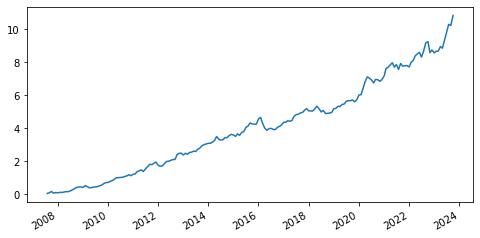

In [39]:
((graph4['long_fwd_rtn']+ 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph4['long_fwd_rtn'] > 0)*1) / len(graph4)

0.5743589743589743

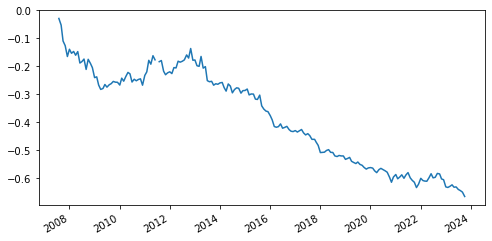

In [40]:
((graph4['short_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph4['short_fwd_rtn']< 0)*1) / len(graph4)

In [41]:
mid4

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
2007-08-01,0.616071,0.090909,1.000000,0.925000,1.000000,1.000000,0.987578
2007-09-03,0.300000,0.398148,1.000000,0.885906,0.945055,0.906077,0.987805
2007-10-01,0.714286,0.169231,1.000000,0.922078,0.685714,1.000000,1.000000
2007-11-01,0.142857,0.727273,1.000000,0.926136,1.000000,0.911392,0.000000
2007-12-03,1.000000,1.000000,0.000000,0.000000,0.027027,0.061728,0.788462
...,...,...,...,...,...,...,...
2023-06-01,0.684211,0.294416,0.774194,0.109091,0.986842,0.000000,0.478873
2023-07-03,0.000000,0.136564,1.000000,0.117117,1.000000,0.878788,0.893939
2023-08-01,0.518072,0.616438,0.000000,0.551724,0.088235,0.750000,0.216216
2023-09-01,0.000000,0.311284,0.400000,0.519231,0.027027,0.765957,0.200000


### Random Forest

In [214]:
from sklearn.ensemble import RandomForestClassifier
ensemble_model = VotingClassifier(estimators=[
    ('cart', DecisionTreeClassifier()),
    ('svm_poly', SVC(probability=True)),
    ('logistic', LogisticRegression()),
    ('random_forest', RandomForestClassifier(n_estimators=50))
    ], voting='soft')  # 'soft'은 클래스 확률의 평균을 사용하여 다수결을 결정

mid5 = simulation_model(data_list, model = ensemble_model)
graph5 = simulation_performace_graph(mid5)

NameError: name 'VotingClassifier' is not defined

0.7759562841530054

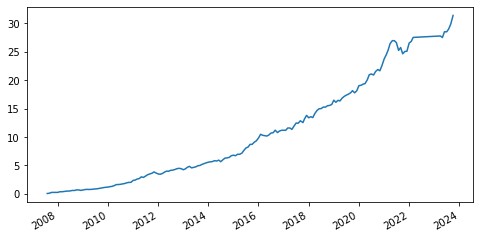

In [82]:
((graph5['long_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph5['long_fwd_rtn'] > 0)*1) / len(graph5)

0.7158469945355191

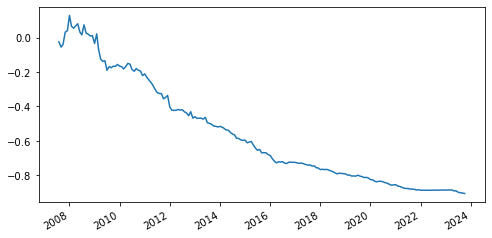

In [83]:
((graph5['short_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph5['short_fwd_rtn']< 0)*1) / len(graph5)

In [92]:
mid5

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
2007-08-01,0.646042,0.324161,0.819494,0.607232,0.871855,0.410204,0.321357
2007-09-03,0.704050,0.142801,0.895921,0.735807,0.663011,0.521543,0.438245
2007-10-01,0.744447,0.597898,0.892726,0.440549,0.853427,0.606808,0.360189
2007-11-01,0.781740,0.364210,0.592380,0.924057,0.745984,0.746994,0.428658
2007-12-03,0.800004,0.301951,0.457534,0.406118,0.444860,0.282616,0.772487
...,...,...,...,...,...,...,...
2023-06-01,0.837494,0.258888,0.643112,0.149202,0.885557,0.224689,0.642241
2023-07-03,0.492616,0.209327,0.593991,0.125813,0.803913,0.509644,0.600021
2023-08-01,0.655892,0.735555,0.255098,0.862969,0.374795,0.100719,0.761326
2023-09-01,0.316744,0.649875,0.363951,0.736379,0.481938,0.149516,0.667983


### KNN (K-Nearest Neighbors)

In [215]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors=4, metric='minkowski')

mid6 = simulation_model(data_list, model = knn)
graph6 = simulation_performace_graph(mid6)

0.6830601092896175

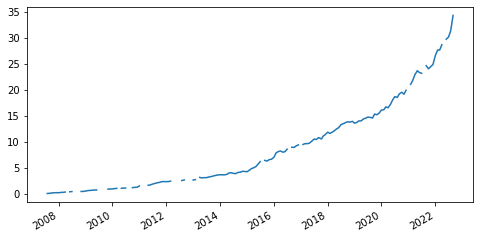

In [216]:
((graph6['long_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph6['long_fwd_rtn'] > 0)*1) / len(graph6)

0.7213114754098361

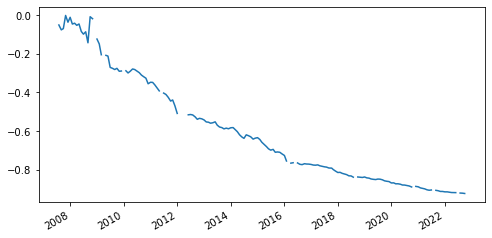

In [217]:
((graph6['short_fwd_rtn'] + 1).cumprod() - 1).plot(figsize=(8,4))
sum((graph6['short_fwd_rtn']< 0)*1) / len(graph6)

In [218]:
mid6.head(10)

,Growth,Market,Price_mmt,Profitability,Sentiment,Stability,value
2007-08-01,0.50,0.00,1.00,1.00,1.00,0.25,0.50
2007-09-03,0.25,0.00,0.75,1.00,0.75,0.75,0.50
2007-10-01,0.25,0.25,0.25,1.00,1.00,0.50,0.75
2007-11-01,0.75,0.25,0.75,1.00,0.75,0.75,0.25
2007-12-03,0.75,1.00,0.00,0.25,0.00,0.00,1.00
2008-01-02,1.00,0.00,0.00,0.00,1.00,0.50,1.00
2008-02-01,1.00,0.00,1.00,0.25,1.00,0.00,0.00
2008-03-03,0.00,0.75,0.50,1.00,0.75,1.00,1.00
2008-04-01,0.75,0.75,0.00,0.75,1.00,0.25,0.25
2008-05-02,1.00,1.00,0.50,0.50,1.00,1.00,1.00


In [219]:
graph6

,long_fwd_rtn,short_fwd_rtn,LS
2007-08-01,0.041842,-0.050597,0.092440
2007-09-03,0.035201,-0.026733,0.061934
2007-10-01,0.057557,0.007007,0.050550
2007-11-01,0.034514,0.073330,-0.038816
2007-12-03,0.025295,-0.035053,0.060349
...,...,...,...
2022-05-30,0.035621,-0.002486,0.038107
2022-06-30,0.013151,NaN,NaN
2022-07-29,0.037840,-0.026970,0.064810
2022-08-31,0.092524,-0.008923,0.101447
